In [178]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [179]:
# load images
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000,)
(10000, 784)
(10000,)
1.0
0.0


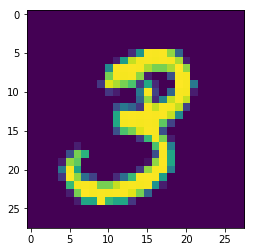

3


In [180]:
# explore data
print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)

print(np.max(train_data))
print(np.min(train_data))

img = train_data[1].reshape(28,28)
plt.imshow(img)
plt.show()
print(train_labels[1])

# Tensorflow

In [181]:
tf.reset_default_graph()

data = tf.placeholder(
    tf.float32, 
    shape=[None, 784], 
    name='x')

labels = tf.placeholder(
    tf.int32, 
    shape=[None], 
    name='y')

# one-hot encode label
onehot_labels = tf.one_hot(indices=labels, depth=10)

# input layer, transform data to 28*28*1
input_layer = input_layer = tf.reshape(data, [-1, 28, 28, 1])

# conv layer1, output 28*28*32
conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

# pooling layer1, output 14*14*32
pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

# conv layer2, output 14*14*64
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

# pool layer2, output 7*7*64
pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

# flatten
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

# full connected layer1
dense = tf.layers.dense(
    inputs=pool2_flat, 
    units=1024, 
    activation=tf.nn.relu)

# output layer
# full connected layer1
output_layer = tf.layers.dense(
    inputs=pool2_flat,
    units=10)

# caculate loss
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=onehot_labels))
optimizer = tf.train.AdamOptimizer().minimize(cost)

predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=output_layer, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(output_layer, name="softmax_tensor")
}

In [183]:
from sklearn.utils import shuffle 

def train_batch_generator(x, y, bs):
    while True:
        new_ind = shuffle(range(len(x)))
        x = np.take(x, new_ind, axis=0)
        y = y.take(new_ind)

        x_train = np.array([]).reshape(0, x.shape[1])
        y_train = np.array([])
        for i in range(x.shape[0]):
            x_train = np.row_stack((x_train, np.array(x[i])))
            y_train = np.append(y_train, y[i])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                y_batch = y_train.copy()
                x_train = np.array([]).reshape(0, x.shape[1])
                y_train = np.array([])
                yield x_batch, y_batch

In [184]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [186]:
epoch = 30
bs = 100

gen = train_batch_generator(train_data, train_labels, bs)

costRec = np.array([])
for i in range(200):
    x_batch, y_batch = next(gen)
    sess.run([optimizer], feed_dict={data:x_batch, labels:y_batch})
    if i%10 == 0:
        crtCost = sess.run([cost], feed_dict={data:x_batch, labels:y_batch})
        print(crtCost)
        costRec = np.append(costRec,crtCost)

[0.9365505]
[0.23540218]
[0.2641505]
[0.24721909]
[0.20076159]
[0.1777809]
[0.20348167]
[0.28633344]
[0.087416]
[0.1062653]
[0.098484755]
[0.20935161]
[0.036967054]
[0.2535326]
[0.15920426]
[0.0992663]
[0.15338622]
[0.061559394]
[0.07140657]
[0.051532947]


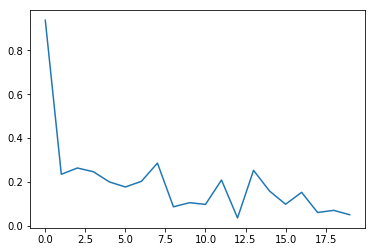

In [191]:
plt.plot(np.arange(len(costRec)), costRec)
plt.show()

In [197]:
test_gen = train_batch_generator(eval_data, eval_labels, 200)
x_test_batch, y_test_batch = next(test_gen)

classes, probs = sess.run(
    [predictions['classes'], predictions['probabilities']],
    feed_dict={data:x_test_batch, labels:y_test_batch})

print(classes)
print(y_test_batch)

accuracy = np.sum(classes.astype(int) == y_test_batch) / len(y_test_batch)
print(accuracy)

[9 2 3 3 5 3 0 8 0 8 0 0 0 7 3 4 8 2 1 9 9 3 1 0 5 5 0 6 8 4 6 7 1 8 0 8 4
 7 5 1 9 3 0 1 7 6 0 8 9 8 0 5 7 9 5 4 5 3 4 7 1 8 6 5 1 2 3 5 4 4 7 8 3 3
 5 3 7 6 2 0 0 7 5 5 6 9 0 5 9 0 7 6 3 0 8 1 3 3 0 5 4 4 9 5 3 7 8 4 1 7 4
 6 8 9 3 6 4 0 6 9 3 4 0 6 6 9 0 6 2 9 1 4 4 0 9 1 3 3 6 2 3 7 2 8 1 3 4 8
 7 8 8 8 8 9 4 1 0 0 6 9 3 5 8 6 6 0 4 0 3 4 8 2 4 7 7 2 6 2 3 3 9 2 1 0 4
 3 1 7 8 6 0 9 1 5 0 3 8 1 5 0]
[9. 2. 3. 3. 5. 3. 0. 2. 0. 8. 0. 0. 0. 7. 3. 4. 8. 2. 1. 9. 9. 3. 7. 0.
 5. 5. 0. 6. 8. 4. 6. 7. 1. 8. 0. 8. 4. 7. 5. 1. 9. 3. 0. 1. 7. 6. 0. 8.
 9. 8. 0. 5. 7. 9. 5. 4. 5. 3. 4. 7. 1. 8. 6. 5. 1. 2. 3. 5. 4. 4. 7. 8.
 3. 3. 5. 3. 7. 6. 2. 0. 0. 7. 5. 5. 6. 9. 0. 5. 9. 0. 7. 6. 3. 0. 8. 1.
 3. 3. 0. 5. 4. 4. 9. 3. 3. 7. 8. 4. 1. 9. 4. 6. 0. 9. 3. 6. 4. 0. 6. 9.
 3. 4. 0. 6. 6. 9. 0. 6. 2. 9. 1. 4. 4. 0. 9. 9. 3. 3. 6. 7. 3. 7. 2. 8.
 1. 8. 8. 8. 7. 8. 8. 8. 8. 9. 4. 1. 0. 0. 6. 9. 3. 5. 8. 6. 6. 0. 4. 0.
 2. 4. 8. 2. 4. 7. 7. 2. 6. 2. 3. 3. 9. 2. 1. 0. 4. 3. 1. 7. 8. 6. 0. 9.
 1. 5. 0.